## **BigMart Sales Prediction**

### **Project Context**
In todayâ€™s retail industry, understanding what factors influence sales is crucial for business success. BigMart, a supermarket chain, has collected sales data from multiple stores to analyze trends and improve revenue forecasting. This project aims to build a **Supervised Learning Model** to predict product sales using **historical sales data and store-related attributes**.

-----------------------------

### **Goal of the Project**
- **Predict `Item_Outlet_Sales`** based on item and store characteristics.
- **Identify key features** that drive sales.
- **Provide business insights** to improve pricing and store management strategies.
## **Dataset** 
-----------------------------
**Data Source:** https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data/data
- Item_Identifier : Unique ID for each product

- Item_Weight : Weight of the product

- Item_Fat_Content : Indicates whether the product is low fat or regular

- Item_Visibility : The percentage of the total display area of all products in a store that allocated to this product

- Item_Type : The product category

- Item_MRP : Maximum Retail Price of the product

- Outlet_Identifier : Unique ID for each store

- Outlet_Establishment_Year : Store Establishment year

- Outlet_Size : The physical size of the store (small, medium, or large)

- Outlet_Location_Type : Classification of the storeâ€™s location

- Outlet_Type : Specifies whether the store is a grocery store or a supermarket

- Item_Outlet_Sales : The total sales of a product in a store (target variable for prediction).

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import ace_tools as tools
import warnings
warnings.filterwarnings("ignore")

In [3]:
#loading data
train_df = pd.read_csv(r'D:\Master\Introduction to Machine Learning Supervised Learning\Data\Train.csv')
test_df = pd.read_csv(r'D:\Master\Introduction to Machine Learning Supervised Learning\Data\Test.csv')

In [3]:
# Display first few rows
train_df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

**Observations:**

- Because of both of **Item_Identifier** and **Outlet_Identifier** are only ID variables, so they don't have any effect of  predictive process to predict the dependent variable - **Item_Outlet_Sales**.
- So, we need to delete these two variables.

In [4]:
# Check dataset shape
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Train Data Shape: (8523, 12)
Test Data Shape: (5681, 11)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [6]:
# check the percentage of missing values
(train_df.isnull().sum() / train_df.shape[0])*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

## Univariate Analysis 

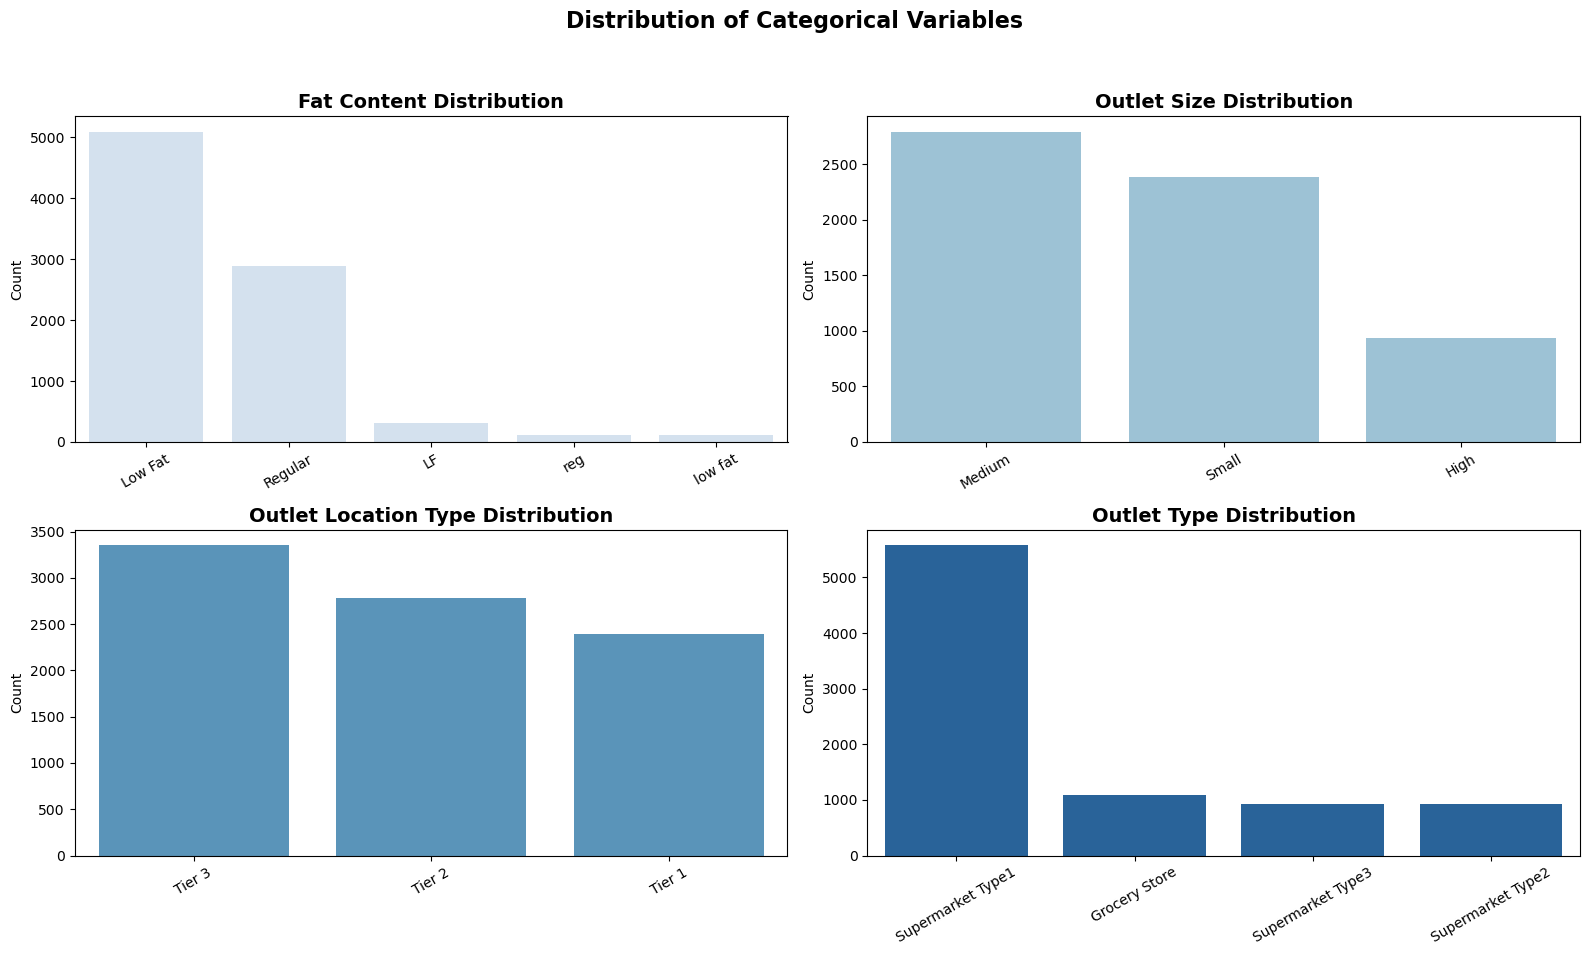

In [8]:
# Define categorical columns for visualization
categorical_features = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
titles = ["Fat Content Distribution", "Outlet Size Distribution", 
          "Outlet Location Type Distribution", "Outlet Type Distribution"]

# Create subplots dynamically
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Distribution of Categorical Variables", fontsize=16, fontweight='bold')

# Set color palette
colors = sns.color_palette("Blues", len(categorical_features))

# Iterate over categorical features and plot countplots
for ax, feature, title, color in zip(axes.flatten(), categorical_features, titles, colors):
    sns.countplot(ax=ax, x=feature, data=train_df, order=train_df[feature].value_counts().index, color=color)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()

**Observations:**

- The **Item_Fat_Content** column contains inconsistencies in labeling, where Low Fat appears as low fat and LF, and Regular is also written as reg. These discrepancies need to be standardized.
- In the **Outlet_Size** column, the most common category is **Medium**, followed by **Small** and **High**.
- The **Outlet_Location_Type** column shows that **Tier 3** is the most frequent category, followed by **Tier 2** and **Tier 1**. This aligns with the distribution of Outlet_Size, where larger stores are more likely in Tier 1 cities, which are fewer in number, while Medium and Small outlets dominate in Tier 3 and Tier 2 cities due to their higher presence in the dataset.
- For **Outlet_Type**, the majority of stores belong to **Supermarket Type 1**, while **Supermarket Type 2**, **Supermarket Type 3**, and **Grocery Store** categories have significantly fewer, almost equal, representations.

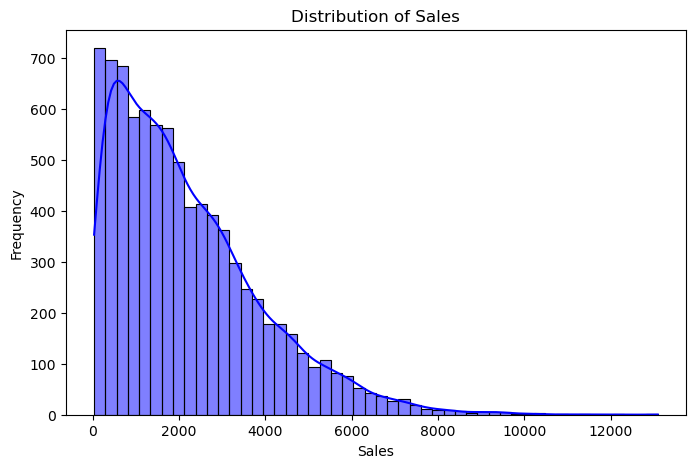

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df["Item_Outlet_Sales"], bins=50, kde=True, color="blue")
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

### **Observations:**
- Right-skewed distribution: Most products have low to moderate sales, with a few high-sales outliers.
- Peak around 0 - 2000 sales, indicating most items sell in this range.
- Long tail effect: Some items generate exceptionally high sales (potential outliers).

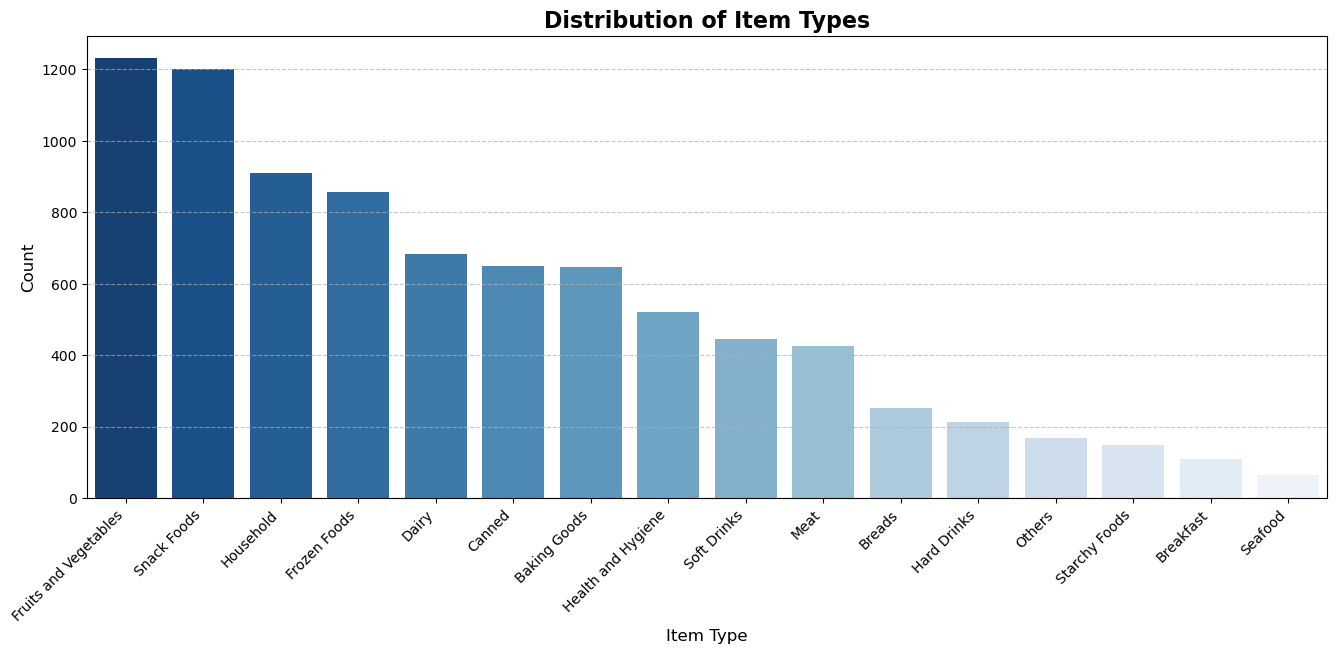

In [10]:
plt.figure(figsize=(16, 6))
sns.countplot(x='Item_Type', data=train_df, order=train_df['Item_Type'].value_counts().index, 
              palette="Blues_r")

plt.title("Distribution of Item Types", fontsize=16, fontweight='bold')
plt.xlabel("Item Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better visualization
plt.show()


**Observation:**

- The plot shows that **Fruits** and **Vegetables** are the most sold items, followed by **Snack Foods** and **Household items**.

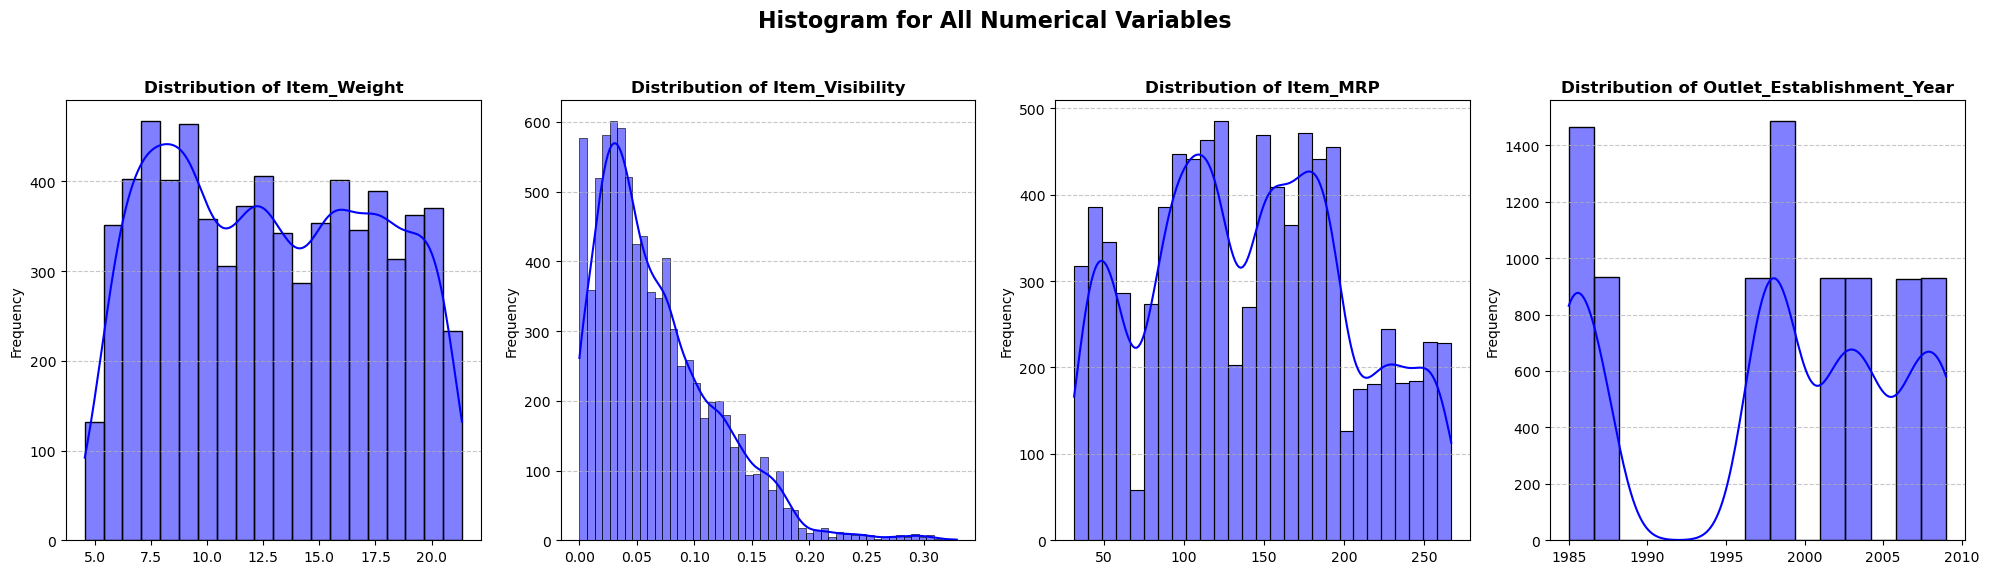

In [11]:
# Select all numerical columns dynamically
numerical_features = train_df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('Item_Outlet_Sales')  # Exclude target variable from histograms

# Define subplot grid dynamically based on the number of numerical features
fig, axes = plt.subplots(1, len(numerical_features), figsize=(20, 6))
fig.suptitle("Histogram for All Numerical Variables", fontsize=16, fontweight='bold')

# Loop through numerical features and create histograms
for ax, feature in zip(axes, numerical_features):
    sns.histplot(train_df[feature], kde=True, ax=ax, color="blue")
    ax.set_title(f"Distribution of {feature}", fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### **Observations:**
- The variable **Item_Weight** is approx uniformly distributed and when we will impute the missing values for this column, we will need to keep in mind that we don't end up changing the distribution significantly after imputing those missing values.
- The variable **Item_Visibility** is a right-skewed distribution which means that there are certain items whose percentage of the display area is much higher than the other items.
- The variable **Item_MRP** is following an approx multi-modal normal distribution.

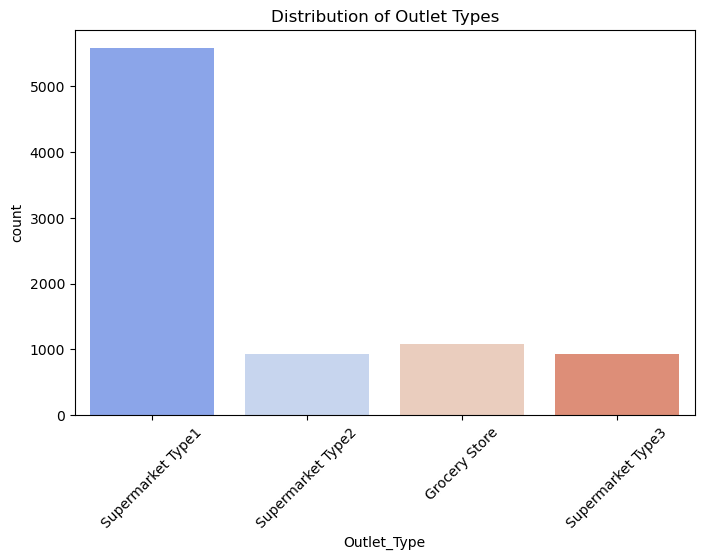

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Outlet_Type", data=train_df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Distribution of Outlet Types")
plt.show()

## Bivariate Analysis 

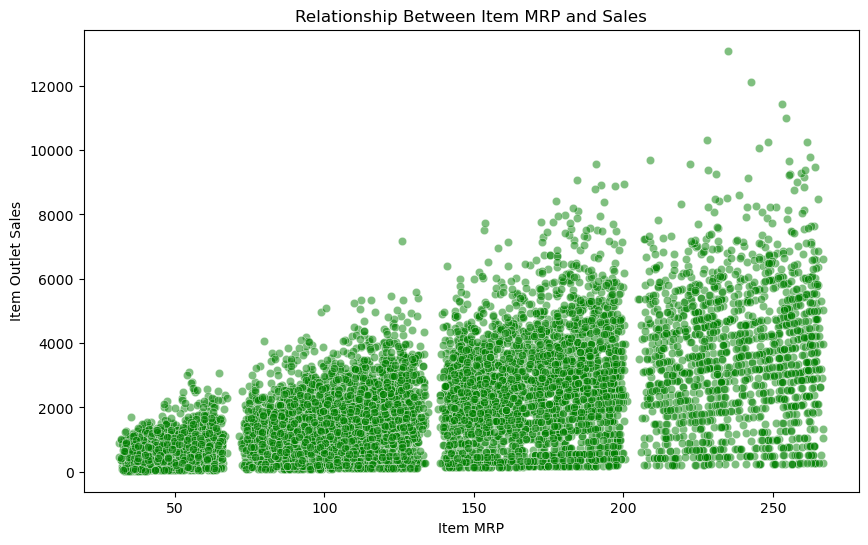

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["Item_MRP"], y=train_df["Item_Outlet_Sales"], alpha=0.5, color="green")
plt.xlabel("Item MRP")
plt.ylabel("Item Outlet Sales")
plt.title("Relationship Between Item MRP and Sales")
plt.show()

### ****Observations**

- Positive Correlation: As Item_MRP increases, Item_Outlet_Sales also increases,This indicates that higher-priced items tend to generate higher sales revenue.
- Step-Like Pattern: The gaps in MRP values suggest MRP is grouped into specific price bands, likely due to round pricing strategies.
Items might be priced at specific points (e.g., 50, 100, 150, etc.) rather than continuously.
- Sales Variability for Same MRP:
Even for the same MRP, sales vary widely, suggesting that factors beyond price (e.g., Outlet_Type, Item_Type) influence sales.


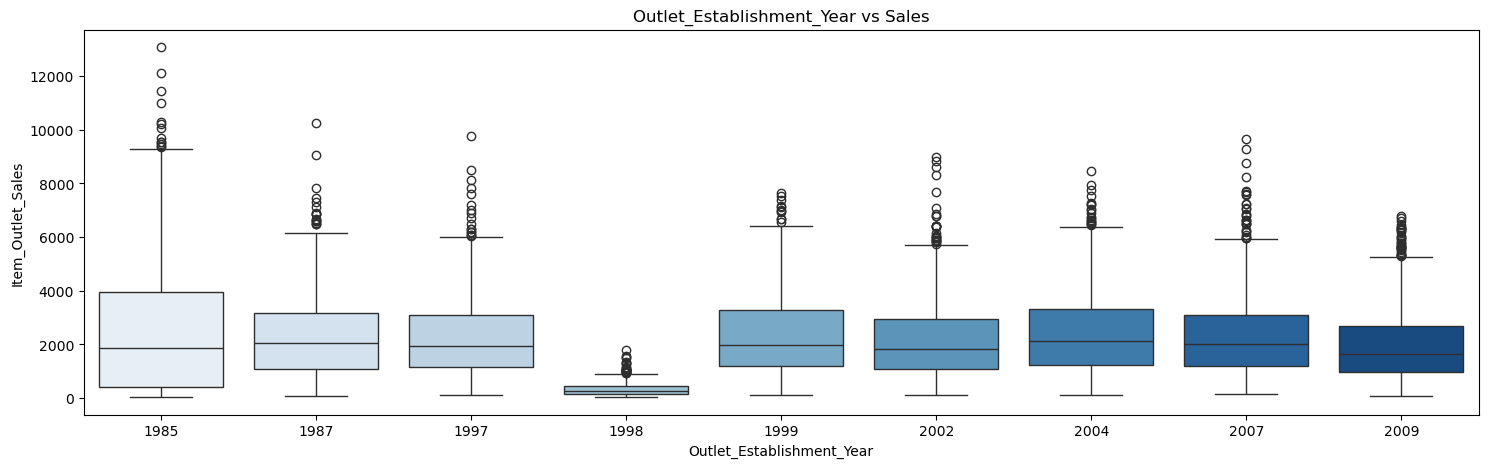

In [38]:
plt.figure(figsize=(18, 5))
sns.boxplot(x="Outlet_Establishment_Year", y="Item_Outlet_Sales", data=train_df, palette="Blues")
plt.title("Outlet_Establishment_Year vs Sales")
plt.show()

#### **Observations:**

- Stores established on 1998 have the lowest sales, indicating underperformance of stores opened that year, not sales in 1998.
- Possible reasons: Different store formats, poor locations, or fewer stores skewing the data.
- Sales distribution is similar across other years, with high-sales outliers in all periods.


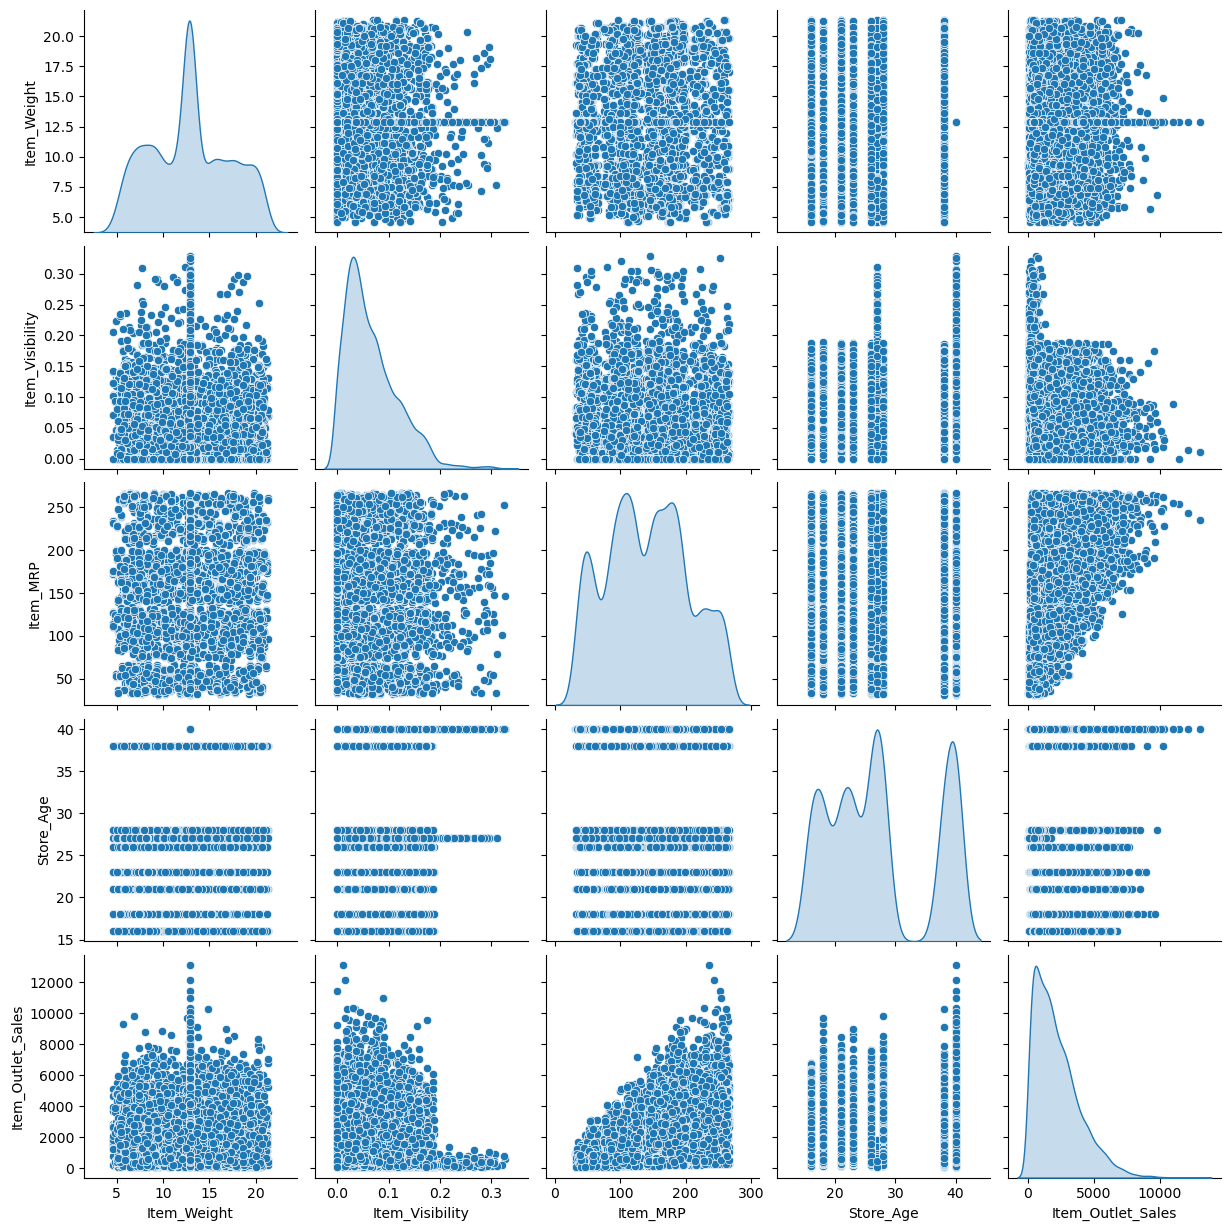

In [23]:
# Pairplot to observe pairwise relationships
sns.pairplot(train_df, vars=["Item_Weight", "Item_Visibility", "Item_MRP", "Store_Age", "Item_Outlet_Sales"], diag_kind='kde')
plt.show()

#### **Observations:**

- **Item_MRP** and **Item_Outlet_Sales** show a positive correlation, meaning higher-priced items tend to generate more revenue.
- **Item_Visibility** has no clear pattern with sales, indicating it may not be a strong predictor.
- **Store_Age** appears segmented, likely due to discrete establishment years rather than continuous data.


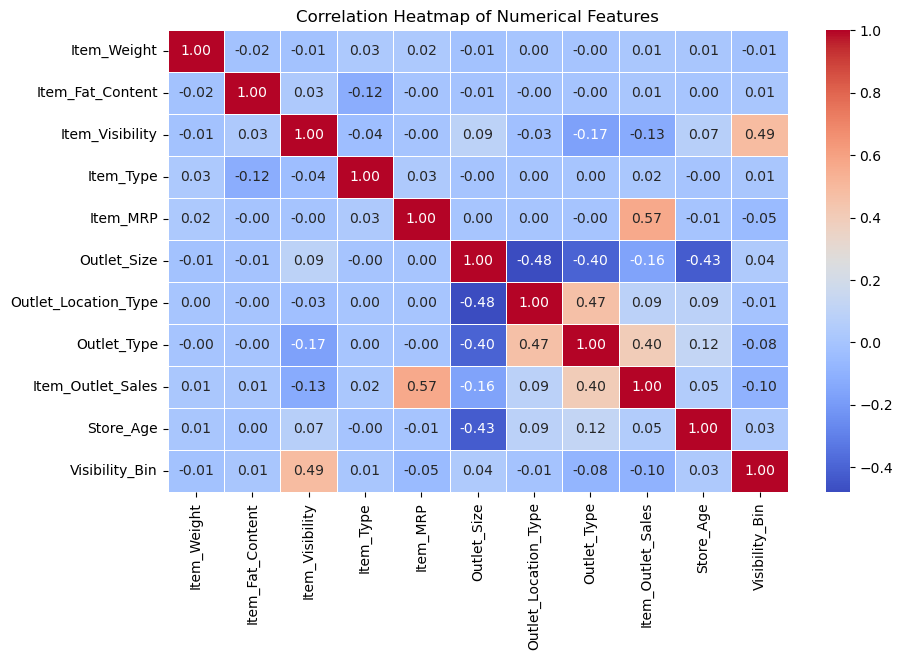

In [24]:
# Correlation heatmap to check feature relationships
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

#### **Observations:**
- Item_MRP has the highest correlation (0.57) with Item_Outlet_Sales, reinforcing its strong influence on sales.
- Item_Visibility has a negative weak correlation (-0.13), confirming its low impact on sales.
- Outlet_Type has some influence (0.40), suggesting that store format affects revenue.
- Most other features have weak correlations, meaning they may not significantly impact sales.

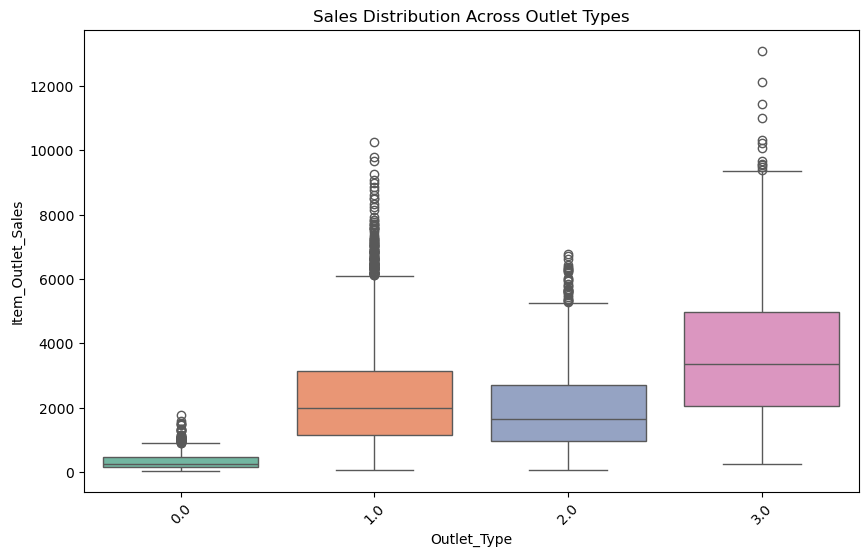

In [25]:
# Boxplot of Outlet Type vs Sales
plt.figure(figsize=(10, 6))
sns.boxplot(x="Outlet_Type", y="Item_Outlet_Sales", data=train_df, palette="Set2")
plt.xticks(rotation=45)
plt.title("Sales Distribution Across Outlet Types")
plt.show()

#### **Observations:**
- Supermarkets (higher category numbers) have higher median sales, while grocery stores (lower category) have significantly lower sales.
- Grocery stores show limited sales variability, indicating a more consistent but lower revenue stream.
- Supermarkets have wider spread and outliers, suggesting that some locations perform exceptionally well while others underperform.

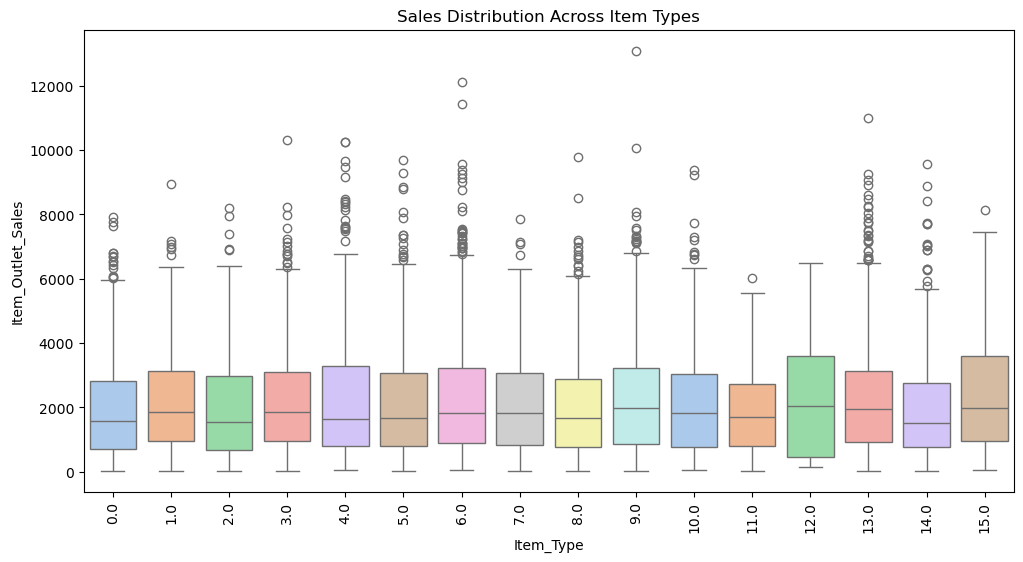

In [26]:
# Relationship between Item Type and Sales
plt.figure(figsize=(12, 6))
sns.boxplot(x="Item_Type", y="Item_Outlet_Sales", data=train_df, palette="pastel")
plt.xticks(rotation=90)
plt.title("Sales Distribution Across Item Types")
plt.show()

#### **Observations:**

- Sales distribution is fairly consistent across all item types
-  Presence of high-sales outliers in all categories
- Interquartile range (IQR) is similar for all categories

This means that most items fall within a similar sales range, regardless of their category.

## Feature Engineering and Data Preprocessing 

In [4]:
# Convert Outlet_Establishment_Year to Store Age
train_df["Store_Age"] = 2025 - train_df["Outlet_Establishment_Year"]
test_df["Store_Age"] = 2025 - test_df["Outlet_Establishment_Year"]

In [5]:
# Scale numerical features using StandardScaler
num_columns = [ "Item_Visibility", "Item_MRP", "Store_Age"]
scaler = StandardScaler()
train_df[num_columns] = scaler.fit_transform(train_df[num_columns])
test_df[num_columns] = scaler.transform(test_df[num_columns])

In [6]:
# Drop unnecessary columns
train_df.drop(columns=["Item_Identifier", "Outlet_Identifier", "Outlet_Establishment_Year"], inplace=True)
test_df.drop(columns=["Item_Identifier", "Outlet_Identifier", "Outlet_Establishment_Year"], inplace=True)

In [7]:
# Create Visibility Bins
train_df["Visibility_Bin"] = pd.qcut(train_df["Item_Visibility"], q=4, labels=["Low", "Medium", "High", "Very High"])
test_df["Visibility_Bin"] = pd.qcut(test_df["Item_Visibility"], q=4, labels=["Low", "Medium", "High", "Very High"])

In [8]:
#Encoding Categorical Variables
cat_columns = ["Item_Fat_Content", "Item_Type", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Visibility_Bin"]
encoder = OrdinalEncoder()
train_df[cat_columns] = encoder.fit_transform(train_df[cat_columns])
test_df[cat_columns] = encoder.transform(test_df[cat_columns])

In [9]:
train_df.isnull().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
Store_Age                  0
Visibility_Bin             0
dtype: int64

In [10]:
# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
train_df[["Item_Weight"]] = imputer.fit_transform(train_df[["Item_Weight"]])
test_df[["Item_Weight"]] = imputer.transform(test_df[["Item_Weight"]])

In [11]:
train_df.isnull().sum()

Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
Store_Age                  0
Visibility_Bin             0
dtype: int64

In [12]:
# Fill missing Outlet_Size based on mode (most frequent category) within Outlet_Type
train_df["Outlet_Size"] = train_df.groupby("Outlet_Type")["Outlet_Size"].transform(lambda x: x.fillna(x.mode()[0]))
test_df["Outlet_Size"] = test_df.groupby("Outlet_Type")["Outlet_Size"].transform(lambda x: x.fillna(x.mode()[0]))


In [13]:
train_df.isnull().sum()

Item_Weight             0
Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
Store_Age               0
Visibility_Bin          0
dtype: int64

## Modeling

In [14]:
# Define target variable and features
X = train_df.drop(columns=["Item_Outlet_Sales"])
Y = train_df["Item_Outlet_Sales"]

In [15]:
# Apply log transformation to stabilize variance and improve model performance
train_df["Log_Sales"] = np.log(train_df["Item_Outlet_Sales"])
y_train = train_df["Log_Sales"] # Assign transformed target variable

In [16]:
# Redefine feature set after transformation
X = train_df.drop(columns=["Item_Outlet_Sales", "Log_Sales"])
Y = train_df["Log_Sales"]  # Use log-transformed target variable

In [17]:
# Split dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [18]:
# Drop irrelevant categorical variables that are not useful for prediction
X_train = X_train.drop(columns=["Outlet_Location_Type", "Visibility_Bin"])
X_val = X_val.drop(columns=["Outlet_Location_Type", "Visibility_Bin"])
test_df = test_df.drop(columns=["Outlet_Location_Type", "Visibility_Bin"])

In [19]:
# Select only numerical features for VIF calculation
num_features = X_train.select_dtypes(include=['number'])

# Compute VIF for each numerical feature to detect multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = num_features.columns
vif_data["VIF"] = [variance_inflation_factor(num_features.values, i) for i in range(len(num_features.columns))]

# Display VIF values in descending order (higher values indicate multicollinearity)
print(vif_data.sort_values(by="VIF", ascending=False))

            Feature       VIF
0       Item_Weight  7.201967
5       Outlet_Size  5.309054
1  Item_Fat_Content  4.540606
3         Item_Type  3.585629
6       Outlet_Type  3.115455
7         Store_Age  1.192191
2   Item_Visibility  1.050325
4          Item_MRP  1.001562


In [20]:
# Remove highly collinear feature (Item_Weight) based on high VIF value

X_train = X_train.drop(columns=["Item_Weight"])
X_val = X_val.drop(columns=["Item_Weight"])
test_df = test_df.drop(columns=["Item_Weight"])

In [21]:
# Define hyperparameter grid for Random Forest tuning using GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200], # Number of trees in the forest
    "max_depth": [5, 10, 15], # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],  #Minimum samples required to split an internal node
    "min_samples_leaf": [1, 2, 4] # Minimum samples required to be at a leaf node
}

In [22]:
# Initialize Random Forest Regressor with multiple parallel jobs for faster training
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

In [23]:
# Perform GridSearchCV to find best hyperparameters
# GridSearchCV systematically tests different hyperparameter combinations using cross-validation (cv=3)
# It evaluates the model performance using 'neg_root_mean_squared_error' (negative RMSE) as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

## Insights:
- GridSearchCV tested 81 different hyperparameter combinations (3 folds x 81 candidates = 243 fits).
- The best hyperparameters were chosen based on the lowest RMSE.
- This approach helps avoid overfitting by validating across multiple subsets of data.

In [24]:
# Retrieve the best hyperparameters from the GridSearchCV results
best_params = grid_search.best_params_
print("\nâœ… Best Hyperparameters Found:", best_params)


âœ… Best Hyperparameters Found: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## insight:
- If the chosen max_depth is low (e.g., 5), it suggests the model avoids overfitting by limiting tree depth.
- If n_estimators is high (e.g., 200), it means more trees improve stability but increase training time.

In [25]:
# Train optimized Random Forest with the best hyperparameters
# We now use the best parameters found from GridSearchCV to retrain the Random Forest model
optimized_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
optimized_rf.fit(X_train, y_train)
optimized_rf_preds = optimized_rf.predict(X_val)

In [26]:
# Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

## **Evaluation Metrics**

**- Root Mean Squared Error (RMSE):**

- Measures the average prediction error in the original scale of the target variable.
- Lower RMSE means better predictions with fewer large errors.

**-RÂ² Score (Coefficient of Determination):**

- Measures how well the model explains the variance in the target variable.
- Higher RÂ² (closer to 1) means better model performance.

In [27]:
# Evaluate Random Forest Performance
optimized_rf_rmse = root_mean_squared_error(y_val, optimized_rf_preds)
optimized_rf_r2 = r2_score(y_val, optimized_rf_preds)


In [28]:
# Evaluate XGBoost Performance
xgb_rmse = root_mean_squared_error(y_val, xgb_preds)
xgb_r2 = r2_score(y_val, xgb_preds)

In [29]:
# Create a summary of model performance
model_performance = pd.DataFrame({
    "Model": ["Random Forest (Optimized)", "XGBoost"],
    "RMSE": [optimized_rf_rmse, xgb_rmse],
    "RÂ² Score": [optimized_rf_r2, xgb_r2]
})

In [30]:
# Display Model Performance
print("\nðŸ“Š Model Performance Comparison:")
print(model_performance)



ðŸ“Š Model Performance Comparison:
                       Model      RMSE  RÂ² Score
0  Random Forest (Optimized)  0.523071  0.740755
1                    XGBoost  0.526273  0.737572


### - Random Forest (Optimized) performed slightly better than XGBoost:
    - Lower RMSE (0.5231 vs. 0.5263) â†’ Smaller prediction errors.
    - Higher RÂ² Score (0.7408 vs. 0.7376) â†’ Better variance explanation.
- The performance difference is small, suggesting both models are well-tuned.
- If further improvement is needed, techniques like ensemble stacking or feature engineering could be explored.

In [31]:
# Predict sales on the test dataset using the optimized Random Forest model
test_predictions = optimized_rf.predict(test_df)

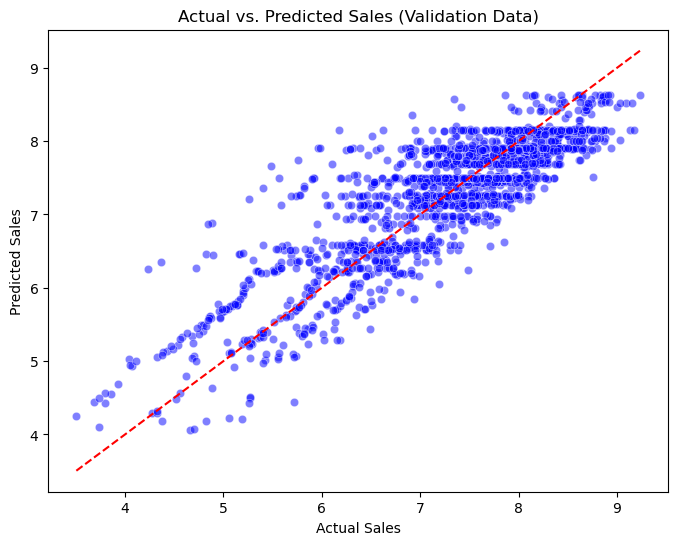

In [37]:
# Generate predictions on validation data
y_pred = optimized_rf.predict(X_val)  # Replace with your trained model

# Scatter plot: Actual vs Predicted Sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.5, color="blue")

# Perfect prediction reference line
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--")

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales (Validation Data)")
plt.show()


## Observations
- Most points are close to the red dashed line, which represents perfect predictions (ideal scenario where predicted sales = actual sales).
- Some spread is observedâ€”this indicates variance in predictions, which is normal for real-world datasets.
- Points above the red line: Model overestimated sales.
- Points below the red line: Model underestimated sales.
- At higher sales values , the spread increases, meaning the model has slightly larger errors for high-value predictions.

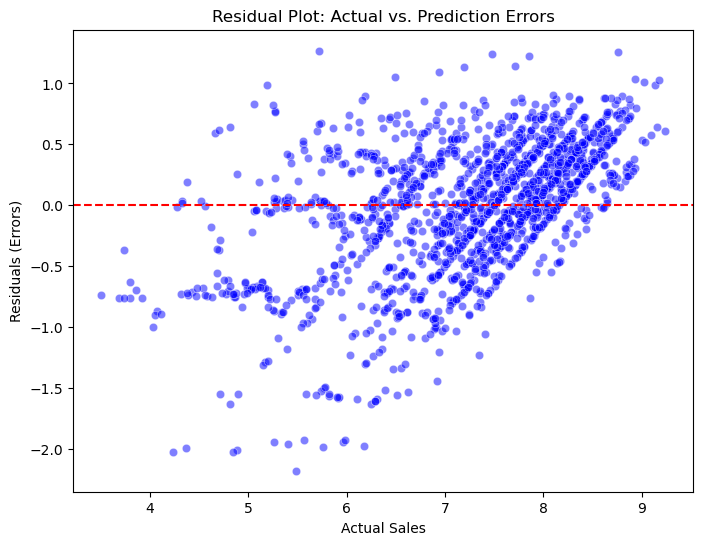

In [38]:
# Calculate residuals
residuals = y_val - y_pred  # Difference between actual and predicted values

# Create residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=residuals, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")  # Zero-error reference line

plt.xlabel("Actual Sales")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot: Actual vs. Prediction Errors")
plt.show()


## Observations
- Residuals are centered around zero, meaning the model has no significant bias.
- No clear pattern in residuals, which indicates a reasonably good fit.
- Some variance at higher sales values (~8-9), meaning the model struggles slightly with larger values.
- Some extreme residuals , suggesting possible outliers or underfitting.

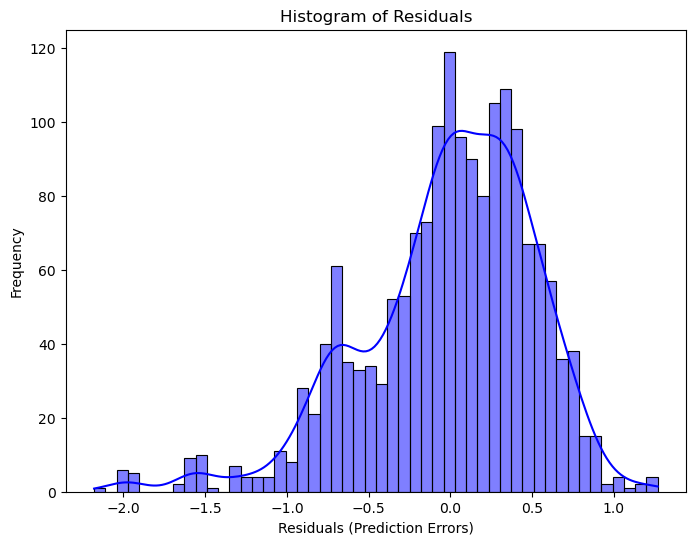

In [39]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color="blue")

plt.xlabel("Residuals (Prediction Errors)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

## Observations
- Residuals are approximately normal, meaning the model's errors are fairly distributed.
- Centered around zero, indicating no significant bias in predictions.
- Some skewness at the tails, meaning there are occasional larger errors.
- Few extreme outliers , suggesting some instances may not be well captured by the model.

In [35]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": optimized_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

In [36]:
# Display Feature Importance for Sales Prediction
print("\nðŸ“Š Feature Importance Ranking:")
print(feature_importance)


ðŸ“Š Feature Importance Ranking:
            Feature  Importance
5       Outlet_Type    0.594286
3          Item_MRP    0.382728
6         Store_Age    0.019503
1   Item_Visibility    0.001969
2         Item_Type    0.001059
0  Item_Fat_Content    0.000456
4       Outlet_Size    0.000000


## Key Takeaways
- Outlet_Type is the most important feature (59.4% importance) â†’ This means the store category significantly impacts sales predictions.
- Item_MRP is the second most important feature (32.7%) â†’ More expensive products influence sales more strongly.
- Other features contribute much less (below 2%) â†’ These features may have limited impact.
- Outlet_Size and Item_Fat_Content have very low importance â†’ They might be candidates for removal to simplify the model.

## How to Use This Information?
- Feature Selection: we might drop low-importance features (Outlet_Size, Item_Fat_Content) if they donâ€™t add value.
- Engineering: If Store_Age has moderate importance, we could create new features like Age Category.
- Business Insights: Sales strategy can be adjusted based on Outlet Type & Price Sensitivity (Item_MRP influence).

# Discussion & Conclusion

## Problem Overview
This project aimed to develop a sales prediction model using Random Forest and XGBoost. The dataset contained key product and store-related features, with Item Outlet Sales as the target variable. We applied log transformation, feature selection, and hyperparameter tuning to improve prediction accuracy.

## Model Performance Summary
- Random Forest slightly outperformed XGBoost, achieving a lower RMSE (0.5231) and higher RÂ² (0.7408).
- The models explain ~74% of the variance in sales, which is a strong indicator of a well-fitted model.
- Both models performed similarly, suggesting that additional tuning or ensemble methods could further refine results.


## Key Insights
### Feature Importance Analysis
- Outlet_Type (59.4%) had the highest impact on sales predictions, meaning the store category significantly influences sales.
- Item_MRP (32.7%) also played a critical role, suggesting that pricing strongly affects sales trends.
- Other features (Store_Age, Visibility, Item Type, etc.) had much lower importance, indicating they contribute less to model predictions.
- Outlet_Size & Item_Fat_Content had minimal impact, suggesting they may not be strong predictors.
## Residual Analysis
- Residuals were normally distributed, centered around zero, meaning no major bias in predictions.
- Some skewness and variance in high sales values, indicating potential heteroscedasticity.
- Few outliers with extreme prediction errors, which could be examined further for better refinement.

## Challenges & Potential Improvements
### Challenges Faced
- Multicollinearity: We used Variance Inflation Factor (VIF) to identify and remove high-multicollinearity features (Item_Weight).
- Prediction Variance: Residual plots indicated increasing error variance at higher sales values.
- Feature Selection Trade-offs: Some features had very low importance but were retained for completeness.

### Future Improvements
- Hyperparameter Fine-Tuning: Using advanced techniques like Bayesian Optimization instead of GridSearchCV.
- Feature Engineering: Creating new interaction features (e.g., Price * Store Type) to capture relationships better.
- Handling Outliers: Applying robust methods like winsorization or quantile-based transformations to reduce extreme errors.
- Ensemble Learning: Combining models through stacking or blending to improve generalization.

## Final Takeaways
- The optimized Random Forest model provided the best performance, though XGBoost was close in accuracy.
- Outlet_Type & Item_MRP were the strongest predictors of sales, suggesting a strong store-category and pricing impact.
- The model generalized well with minimal bias but could improve on extreme value predictions.
- Further refinement through feature selection, hyperparameter tuning, and ensemble methods could enhance results.

## Business Impact & Use Case
- Retail businesses can use this model to forecast sales based on store type and product pricing.
- Insights from feature importance help optimize store operations and pricing strategies.
- Automating sales predictions enables better inventory planning and demand forecasting.

